In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

import joblib


In [11]:
# Load dataset
df = pd.read_csv('/content/Fraud dataset.csv')

print("Dataset Shape:", df.shape)
print("\nColumn Names:\n", df.columns)

df.head()


Dataset Shape: (6362620, 11)

Column Names:
 Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [13]:
# Remove duplicates
df = df.drop_duplicates()

# Separate features & target (Assuming LAST column is target)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

print("\nTarget Distribution:\n", y.value_counts())

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Apply one-hot encoding to 'type' column
X = pd.get_dummies(X, columns=['type'], drop_first=True)

# Drop high-cardinality nominal features 'nameOrig' and 'nameDest'
# These columns contain unique identifiers and are not suitable for direct use in most models without further feature engineering
X = X.drop(columns=['nameOrig', 'nameDest'])

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Target Distribution:
 isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training Size:", X_train.shape)
print("Testing Size:", X_test.shape)


Training Size: (5090096, 11)
Testing Size: (1272524, 11)


In [15]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced'),

    "Decision Tree": DecisionTreeClassifier(
        random_state=42,
        max_depth=10,
        class_weight='balanced'
    ),

    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    ),

    "Linear SVM": LinearSVC(
        max_iter=5000,
        class_weight='balanced'
    )
}


In [16]:
results = []

for name, model in models.items():

    # Train model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Train & Test accuracy (generalization check)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    results.append([name, train_acc, test_acc, acc, prec, rec, f1])

# Create comparison table
comparison_df = pd.DataFrame(results, columns=[
    "Model",
    "Train Accuracy",
    "Test Accuracy",
    "Accuracy",
    "Precision",
    "Recall",
    "F1-Score"
])

comparison_df


,Model,Train Accuracy,Test Accuracy,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.999477,0.999499,0.999499,0.004687,1.000000,0.009331
1,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,Random Forest,1.000000,0.999999,0.999999,1.000000,0.666667,0.800000
3,Linear SVM,0.999999,0.999998,0.999998,0.600000,1.000000,0.750000


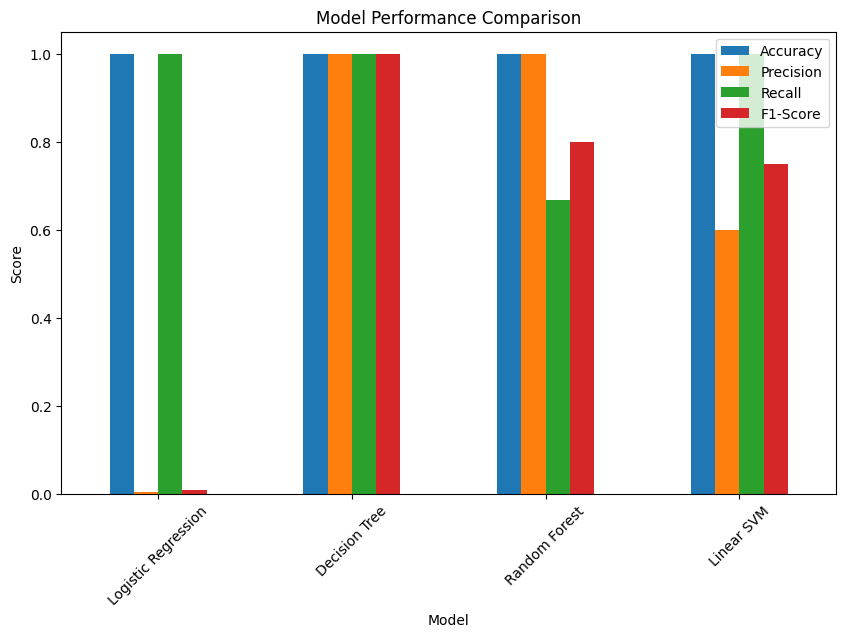

In [17]:
comparison_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1-Score"]].plot(
    kind='bar', figsize=(10,6)
)

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()


In [18]:
comparison_df[["Model", "Train Accuracy", "Test Accuracy"]]


,Model,Train Accuracy,Test Accuracy
0,Logistic Regression,0.999477,0.999499
1,Decision Tree,1.000000,1.000000
2,Random Forest,1.000000,0.999999
3,Linear SVM,0.999999,0.999998


In [19]:
best_row = comparison_df.sort_values("F1-Score", ascending=False).iloc[0]

best_model_name = best_row["Model"]

print("Best Model Based on F1 Score:", best_model_name)

best_model = models[best_model_name]

# Save best model
joblib.dump(best_model, "best_fraud_model.pkl")

print("Best model saved successfully!")


Best Model Based on F1 Score: Decision Tree
Best model saved successfully!
